## Cancer Gene Mutation Classification - Data Visualization

This notebook contains essential visualizations for cancer genomics research, focusing on TP53 gene expression patterns and mutation classification. Each visualization addresses specific medical research needs identified in top-tier cancer genomics publications.


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

plt.style.use('default')
sns.set_palette("husl")

## Class Distribution Analysis - CCLE

**Medical Significance:** CCLE represents the largest cancer cell line genomic dataset available for experimental research. Understanding TP53 mutation distributions in this model system provides essential baseline data for laboratory studies, enabling researchers to select appropriate cell line models that represent the mutation landscape seen in patient tumors for drug screening and mechanistic studies.

In [17]:
# Load CCLE data files using the same variable names from the original notebook
data_mrna_seq_rpkm = pd.read_csv('ccle_data/data_mrna_seq_rpkm.txt', sep='\t', comment='#')
data_mrna_seq_rpkm.set_index('Hugo_Symbol', inplace=True)
data_mrna_seq_rpkm = data_mrna_seq_rpkm.groupby(data_mrna_seq_rpkm.index).mean()

mutations = pd.read_csv('ccle_data/mutations.txt', sep='\t', comment='#')
mutations.set_index('SAMPLE_ID', inplace=True)

data_mutations = pd.read_csv('ccle_data/data_mutations.txt', sep='\t', comment='#')
data_mutations = data_mutations[data_mutations['Hugo_Symbol'] == 'TP53']
data_mutations = data_mutations[['Tumor_Sample_Barcode', 'Variant_Type']]
data_mutations.set_index('Tumor_Sample_Barcode', inplace=True)

# Prepare aligned datasets using your approach
data_t = data_mrna_seq_rpkm.T
code = {"SNP": 0, "DNP": 1, "DEL": 2, "INS": 3}

# Build target vector y and aligned expression matrix X
y = []
X_rows = []
sample_names = []
c = 0

# iterate over each mutation record
for bc, mut in data_mutations.iterrows():
    # check if this barcode is in data_t's index
    if bc in data_t.index:
        # grab the full row from data_t and store it
        X_rows.append(data_t.loc[bc].values)
        y.append(mut['Variant_Type'])  # Keep as string for visualization
        sample_names.append(bc)
    else:
        c += 1

print(f"Number of samples discarded: {c}")

# build a new DataFrame X from the collected rows
X = pd.DataFrame(X_rows, index=sample_names, columns=data_t.columns)
y = np.array(y)

print(f"Original gene expression data shape: {data_mrna_seq_rpkm.shape}")
print(f"Original mutations data shape: {mutations.shape}")
print(f"TP53 mutations data shape: {data_mutations.shape}")
print(f"Final aligned expression data shape: {X.shape}")
print(f"Final aligned mutation data length: {len(y)}")
print(f"Unique mutation types: {np.unique(y)}")

/var/folders/td/9b2gkpts4x33mt091syn5c3w0000gn/T/ipykernel_55056/1936151126.py:9: DtypeWarning: Columns (4,51,53,54,56,57) have mixed types. Specify dtype option on import or set low_memory=False.
  data_mutations = pd.read_csv('ccle_data/data_mutations.txt', sep='\t', comment='#')


Number of samples discarded: 287
Original gene expression data shape: (54353, 1156)
Original mutations data shape: (1570, 2)
TP53 mutations data shape: (1218, 1)
Final aligned expression data shape: (931, 54353)
Final aligned mutation data length: 931
Unique mutation types: ['DEL' 'DNP' 'INS' 'SNP']


**Medical Significance:** Class distribution plots are critical in cancer genomics because they reveal data imbalances that directly impact clinical model performance. In precision medicine, understanding TP53 mutation frequency helps identify which variants are common enough to build reliable predictive models and which rare variants may require specialized approaches or larger cohorts.



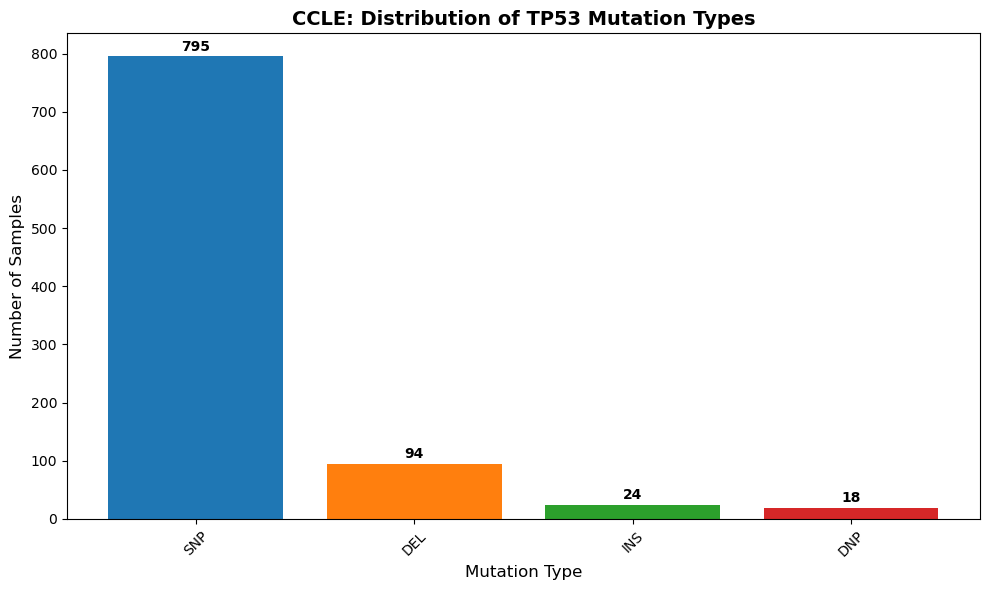

TP53 Mutation distribution:
SNP: 795 (85.4%)
DEL: 94 (10.1%)
INS: 24 (2.6%)
DNP: 18 (1.9%)


In [18]:
# Class Distribution Plot for CCLE
plt.figure(figsize=(10, 6))
mutation_counts = pd.Series(y).value_counts()

bars = plt.bar(mutation_counts.index, mutation_counts.values, 
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.title('CCLE: Distribution of TP53 Mutation Types', fontsize=14, fontweight='bold')
plt.xlabel('Mutation Type', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=45)

# Add count labels on bars
for bar, count in zip(bars, mutation_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("TP53 Mutation distribution:")
for mut_type, count in mutation_counts.items():
    percentage = (count / mutation_counts.sum()) * 100
    print(f"{mut_type}: {count} ({percentage:.1f}%)")

**Medical Significance:** Expression heatmaps are the gold standard in cancer genomics publications. They reveal gene expression patterns across different TP53 mutation groups, enabling identification of biomarkers and therapeutic targets. This visualization shows which genes are differentially expressed between TP53 mutation types, directly informing precision medicine approaches.


/opt/anaconda3/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1600x1000 with 0 Axes>

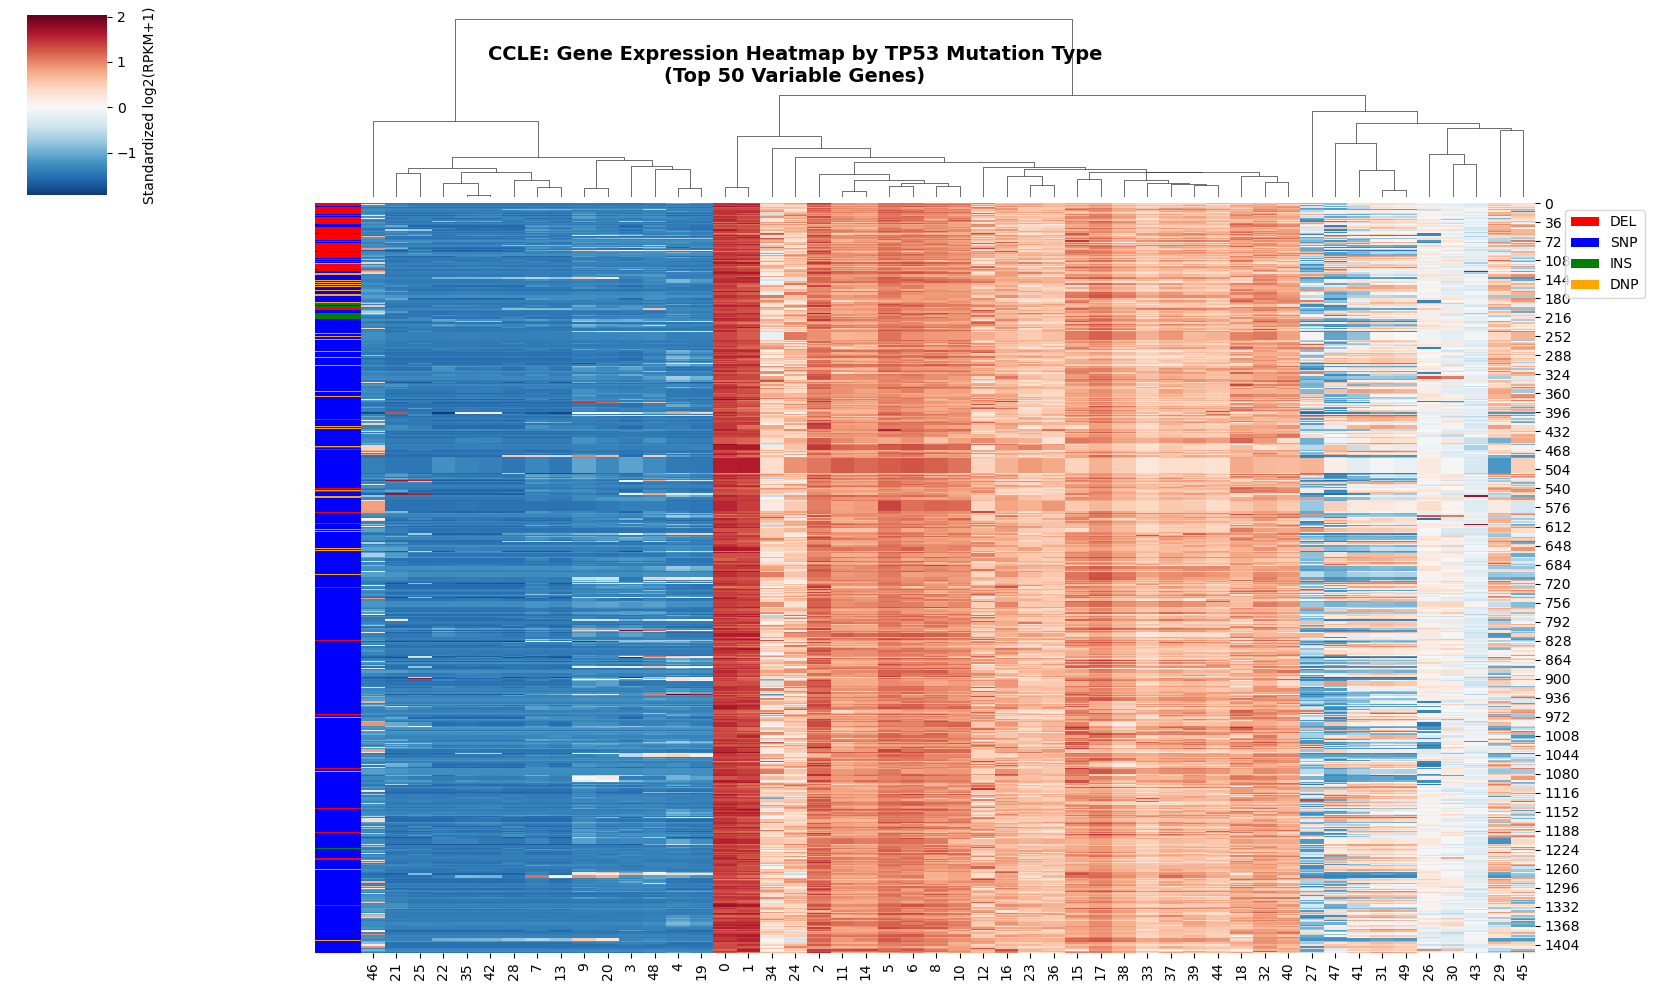

In [19]:
# Prepare data for heatmap using aligned data
# Select top 50 most variable genes
gene_variance = X.var(axis=0).sort_values(ascending=False)
top_genes = gene_variance.head(50).index
expr_heatmap = X[top_genes]

# Create mutation series for sorting
mut_series = pd.Series(y, index=X.index)
sorted_samples = mut_series.sort_values().index
expr_heatmap_sorted = expr_heatmap.loc[sorted_samples]
mut_colors = mut_series.loc[sorted_samples]

# Create heatmap
plt.figure(figsize=(16, 10))

# Create color mapping for mutations
unique_mutations = mut_colors.unique()
color_map = dict(zip(unique_mutations, ['red', 'blue', 'green', 'orange']))
row_colors = [color_map[mut] for mut in mut_colors]

# Log transform and standardize
expr_log = np.log2(expr_heatmap_sorted + 1)
expr_std = StandardScaler().fit_transform(expr_log.T).T

# Create the heatmap
g = sns.clustermap(expr_std, 
                   row_cluster=False, 
                   col_cluster=True,
                   row_colors=row_colors,
                   cmap='RdBu_r',
                   center=0,
                   figsize=(16, 10),
                   cbar_kws={'label': 'Standardized log2(RPKM+1)'})

g.fig.suptitle('CCLE: Gene Expression Heatmap by TP53 Mutation Type\n(Top 50 Variable Genes)', 
               fontsize=14, fontweight='bold', y=0.95)

# Add legend for mutation types
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color_map[mut], label=mut) for mut in unique_mutations]
g.ax_heatmap.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1))

plt.show()

**Medical Significance:** PCA plots demonstrate whether TP53 mutation types form distinct clusters in high-dimensional gene expression space. This is crucial for understanding if different TP53 mutation types have characteristic expression signatures that could be used for classification, prognosis, or treatment selection in clinical settings.


PCA input shapes - X: (931, 54353), y: (931,)


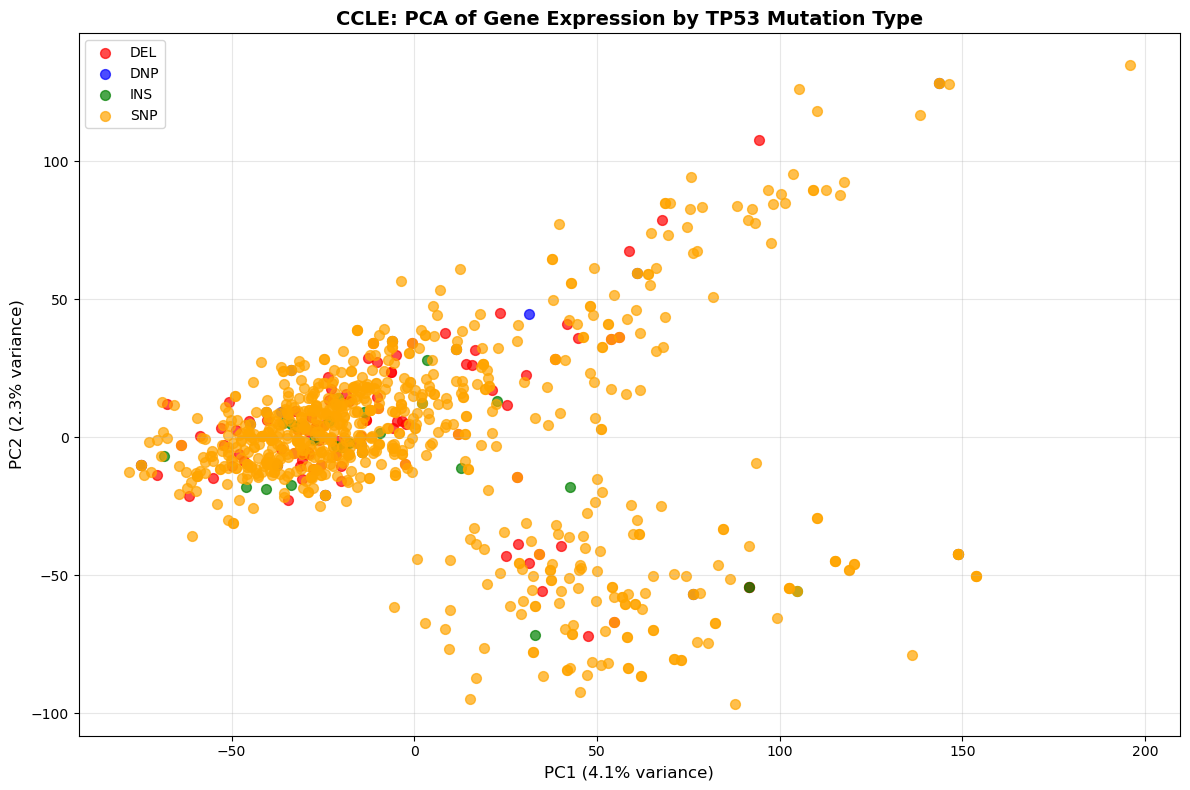

Total variance explained by PC1 and PC2: 6.4%


In [20]:
# PCA Analysis using aligned data
X_pca = X.values
y_pca = y

print(f"PCA input shapes - X: {X_pca.shape}, y: {y_pca.shape}")

# Apply PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)
pca = PCA(n_components=2)
X_pca_transformed = pca.fit_transform(X_scaled)

# Create PCA plot
plt.figure(figsize=(12, 8))
colors = ['red', 'blue', 'green', 'orange']
mutation_types = np.unique(y_pca)

for i, mut_type in enumerate(mutation_types):
    mask = y_pca == mut_type
    plt.scatter(X_pca_transformed[mask, 0], X_pca_transformed[mask, 1], 
                c=colors[i], label=mut_type, alpha=0.7, s=50)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
plt.title('CCLE: PCA of Gene Expression by TP53 Mutation Type', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total variance explained by PC1 and PC2: {pca.explained_variance_ratio_[:2].sum():.1%}")

**Medical Significance:** Box plots showing expression distributions across TP53 mutation groups are essential for identifying genes that could serve as biomarkers. Statistical differences in expression levels between TP53 mutation types can inform treatment decisions and help stratify patients for clinical trials.


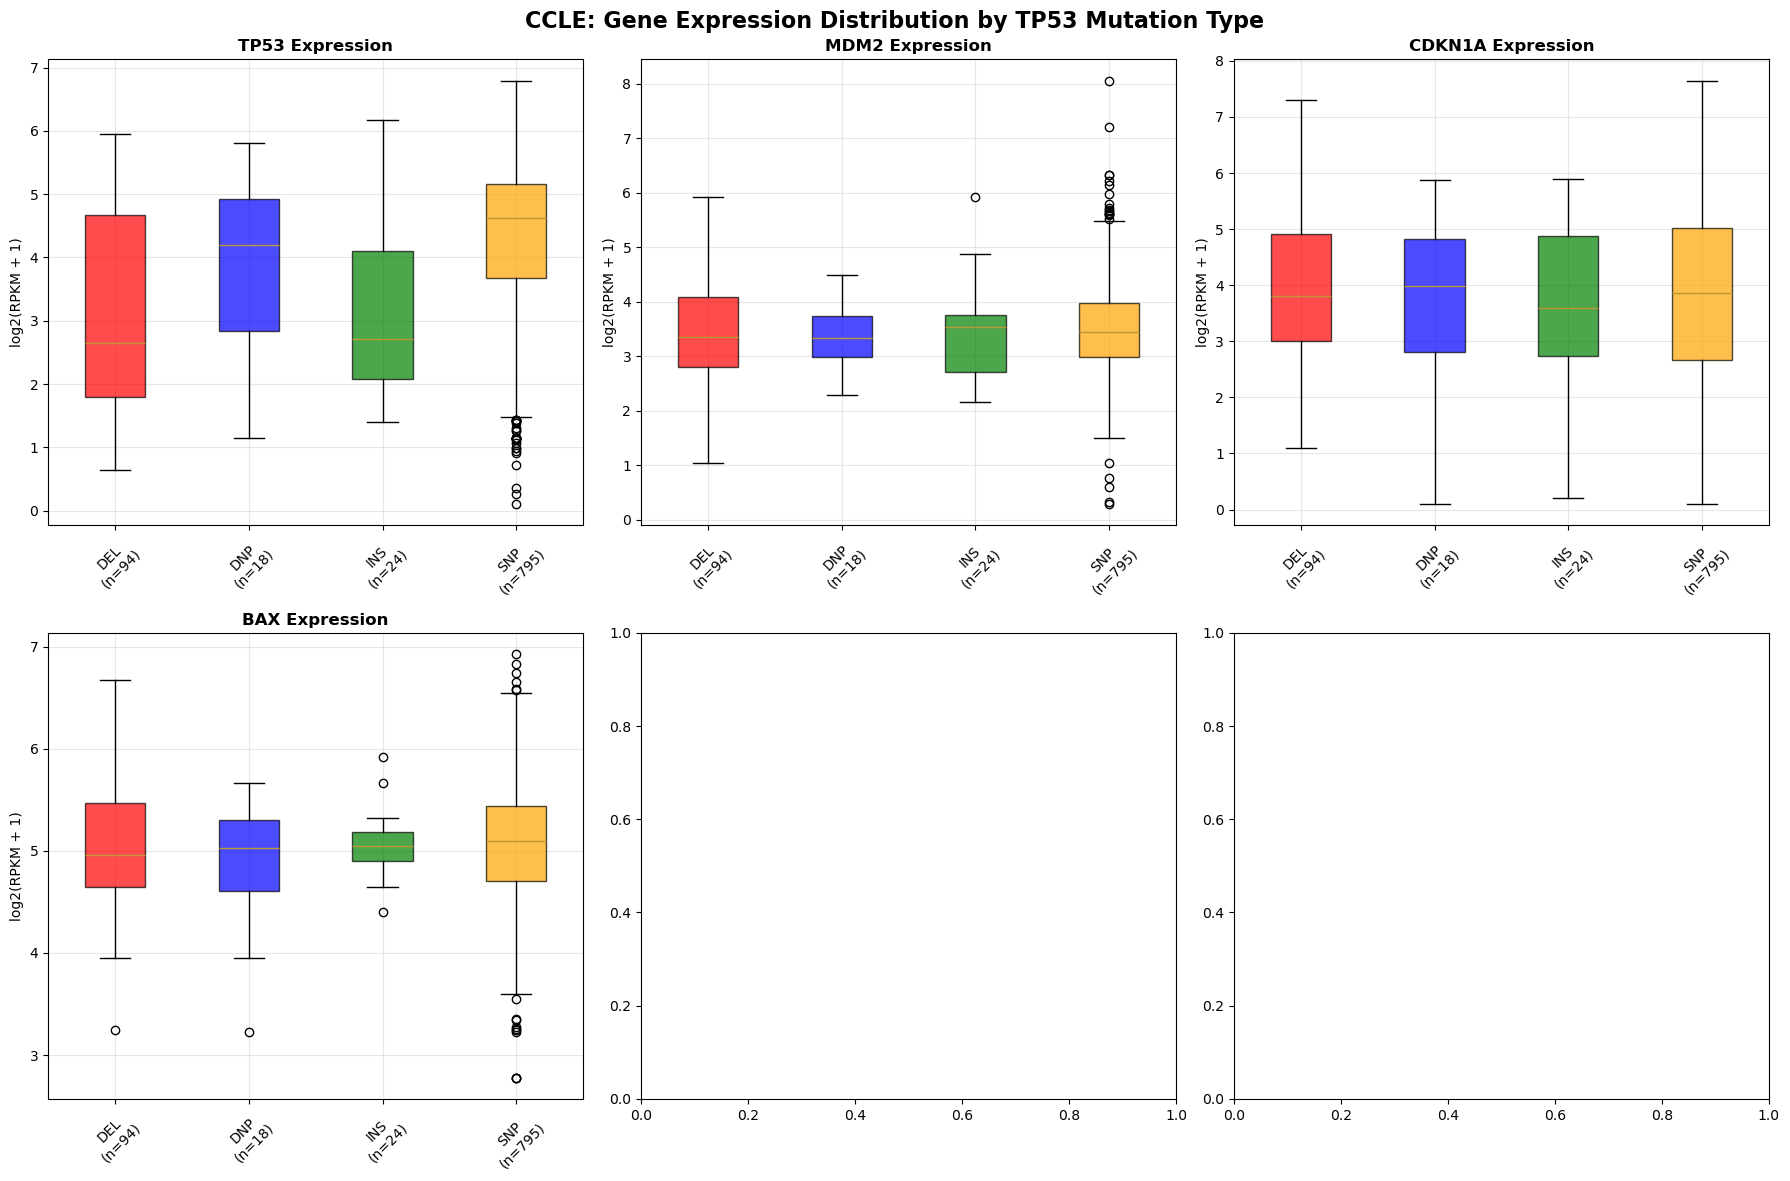

In [21]:
# Expression distribution analysis for key genes using aligned data
key_genes = ['TP53', 'MDM2', 'CDKN1A', 'BAX', 'PUMA']  # TP53 pathway genes
available_genes = [gene for gene in key_genes if gene in X.columns]

if len(available_genes) < 3:
    # If TP53 pathway genes not available, use top variable genes
    available_genes = gene_variance.head(6).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, gene in enumerate(available_genes[:6]):
    # Prepare data for plotting
    plot_data = []
    labels = []
    
    for mut_type in mutation_types:
        mask = y_pca == mut_type
        gene_expr = X[gene].values[mask]
        plot_data.append(np.log2(gene_expr + 1))  # Log transform
        labels.append(f"{mut_type}\n(n={np.sum(mask)})")
    
    # Create box plot
    bp = axes[i].boxplot(plot_data, labels=labels, patch_artist=True)
    
    # Color the boxes
    for patch, color in zip(bp['boxes'], colors[:len(plot_data)]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    axes[i].set_title(f'{gene} Expression', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('log2(RPKM + 1)', fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3)

plt.suptitle('CCLE: Gene Expression Distribution by TP53 Mutation Type', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

**Medical Significance:** Gene-gene correlation matrices reveal co-expression networks that are disrupted in different TP53 mutation contexts. Understanding these relationships is crucial for identifying pathway-level changes and potential combination therapeutic targets in precision oncology.


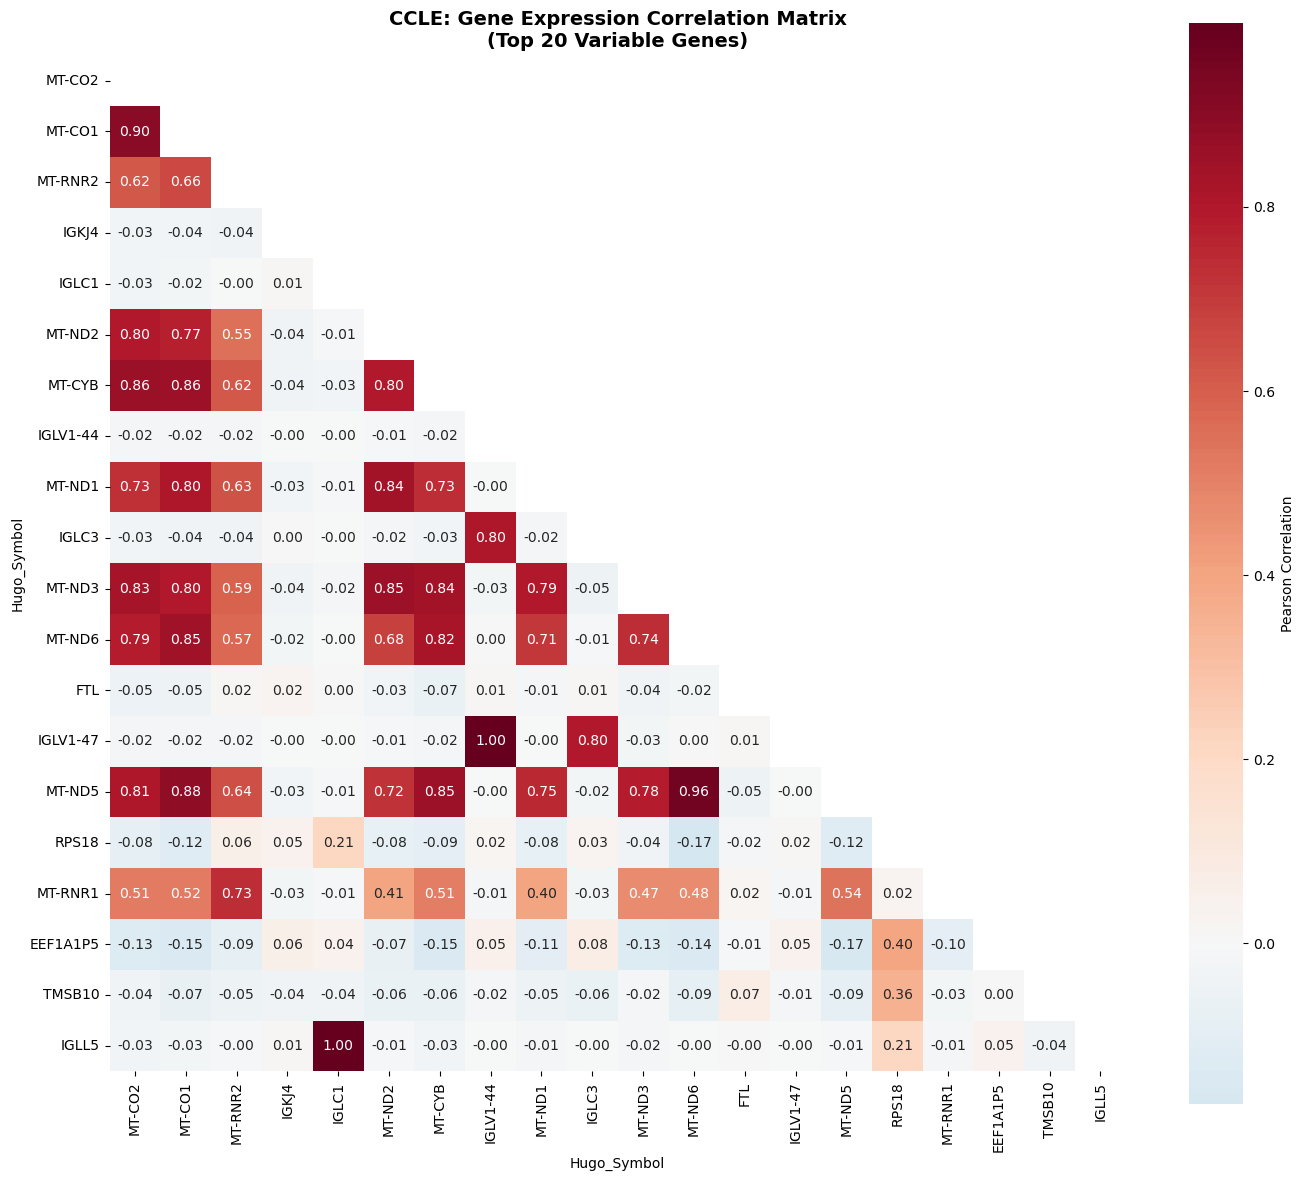

In [22]:
# Correlation matrix for top variable genes
top_20_genes = gene_variance.head(20).index
corr_data = expr_subset[top_20_genes]
correlation_matrix = corr_data.corr()

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='RdBu_r', 
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={'label': 'Pearson Correlation'})

plt.title('CCLE: Gene Expression Correlation Matrix\n(Top 20 Variable Genes)', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()